In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import seaborn as sns
import matplotlib.pyplot as plt

#Import Walmart CSV Dataset 
data = pd.read_csv("/kaggle/input/walmart-dataset/Walmart.csv")

# **Data Collection and Exploration**

*in progress*

# **Data Preprocessing**

In [2]:
#Checking for missing values in dataset ...
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [3]:
data.Date = pd.to_datetime(data.Date,format = "%d-%m-%Y")

data['Weekday'] = data.Date.dt.weekday
data['Month'] = data.Date.dt.month
data['Year'] = data.Date.dt.year

data.drop(['Date'], axis = 1, inplace=True)

#Displaying column info for dataset ...
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
 7   Weekday       6435 non-null   int32  
 8   Month         6435 non-null   int32  
 9   Year          6435 non-null   int32  
dtypes: float64(5), int32(3), int64(2)
memory usage: 427.4 KB


# **Data Analysis**

<Axes: >

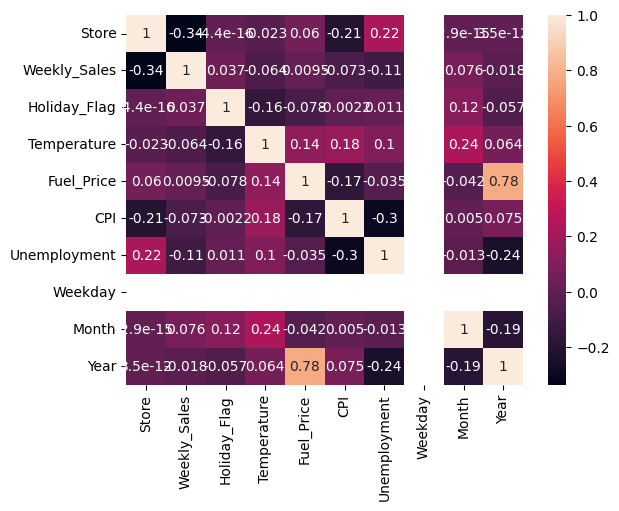

In [4]:
#Creating heatmap for dataset ...
corr_chart = data.corr()
sns.heatmap(corr_chart, annot = True)

# **Model Training**

In [5]:
#Importing all library necessary for model training
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

X = data.drop(['Weekly_Sales'], axis = 1)
y = data['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# **Model Building and Evaluation**

In [6]:
#Calculating the evaluation metrics of the decision tree
def evaluateModel(y_actual, y_predict):
    
    MAE = mean_absolute_error(y_actual, y_predict)
    MSE = mean_squared_error(y_actual, y_predict)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_actual, y_predict)

    print(f"Mean Absolute Error: {MAE}")
    print(f"Mean Squared Error: {MSE}")
    print(f"Root Mean Squared Error: {RMSE}")
    print(f"\nR2 Score: {R2}")

## **1. Decision Tree Regression** 

In [7]:
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(X_train, y_train)
y_pred_regressor = tree_regressor.predict(X_test)

print("\nEvaluation for Decision Tree Regressor Model\n")
evaluateModel(y_test, y_pred_regressor)


Evaluation for Decision Tree Regressor Model

Mean Absolute Error: 89887.41008547008
Mean Squared Error: 30811870570.582767
Root Mean Squared Error: 175533.1039165626

R2 Score: 0.9043568710391744


# **Hyperparameter Tuning**

In [8]:
#Tuning the model to optimise the performance
def tuneModel(estimator, X_train, y_train, param_grid, cv=5):   
    
    grid_search = GridSearchCV(estimator=estimator,
                               param_grid=param_grid,
                               scoring='r2',
                               cv=cv,
                               refit=True)

    # Fit the data
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params} \n")
    print(f"Best R2 score: {best_score}")
    
    best_estimator = grid_search.best_estimator_
    return best_estimator

## **1. Decision Tree Regression** 

In [9]:
param_grid = {'max_depth': np.arange(2, 15),
              'min_samples_split': [10, 20, 30, 40, 50, 100, 200, 300]}

tree_regressor_tuned = tuneModel(tree_regressor, X_train, y_train, param_grid, cv=5)
y_predict_tuned = tree_regressor_tuned.predict(X_test)

Best parameters: {'max_depth': 14, 'min_samples_split': 20} 

Best R2 score: 0.9302612454183297


In [10]:
print("\nEvaluation for tuned Decision Tree Regressor Model\n")
evaluateModel(y_test, y_predict_tuned)


Evaluation for tuned Decision Tree Regressor Model

Mean Absolute Error: 77846.88295391975
Mean Squared Error: 21478919641.288124
Root Mean Squared Error: 146556.881930833

R2 Score: 0.9333272844800193
